### Time Series Analysis and Time Series Models

In [1]:
import os
import sys

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
p = print


In [2]:
p('Machine: {} {}\n'.format(os.uname().sysname,os.uname().machine))
p(sys.version)

Machine: Darwin x86_64

3.7.1 (default, Oct 23 2018, 14:07:42) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
end = '2018-12-12'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY','IWM','RJI']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
# log returns
lrets = np.log(data/data.shift(1)).dropna()

In [4]:
lrets.head()

,SPY,IWM,RJI
Date,,,
2007-10-22,0.005796,0.020896,-0.015937
2007-10-23,0.008071,0.007648,0.011976
2007-10-24,-0.001847,-0.006410,0.000000
2007-10-25,0.002374,-0.002477,0.014771
2007-10-26,0.011654,0.016599,0.009728


### White Noise and Random Walk Models of Time Series

In [5]:
#White noise models have serially incorrelated errors and the expected mean of the error terms is 0
#Another way to characterize these models is that the errores are Independent and and Identically Distributed
#One of the ways we'll know if we've succeeded is if our time series model's error terms resemble a white noise process

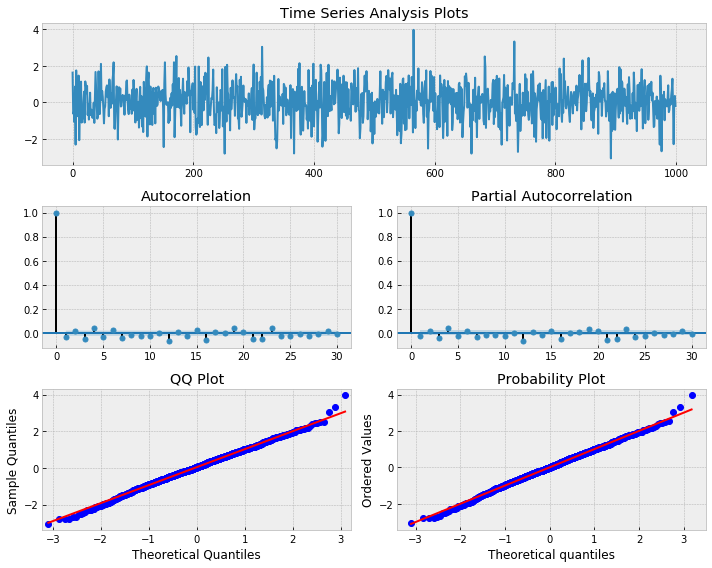

In [7]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

In [8]:
p("Random Series\n -------------\nmean: {:.3f}\nvariance: {:.3f}\nstandard deviation: {:.3f}"
.format(randser.mean(), randser.var(), randser.std()))



Random Series
 -------------
mean: 0.039
variance: 0.962
standard deviation: 0.981


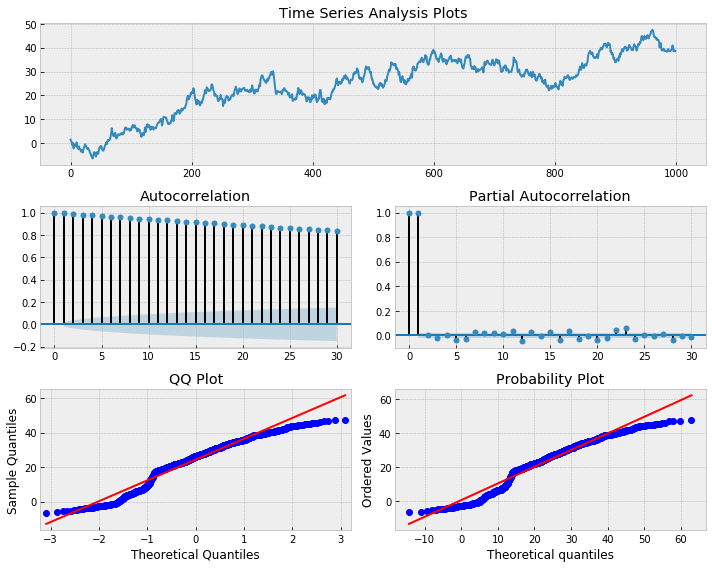

In [9]:
#If covariance between random-walk observations is time-dependent. This time-dependence is non-stationarity
#Since we have a non-stationary process, we cannot predict its future state

np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)


#since the equation of our random_walk model is x_t = x_t-1 + w_t, w_t = x_t - x_t-1 
#which is the first difference between observations

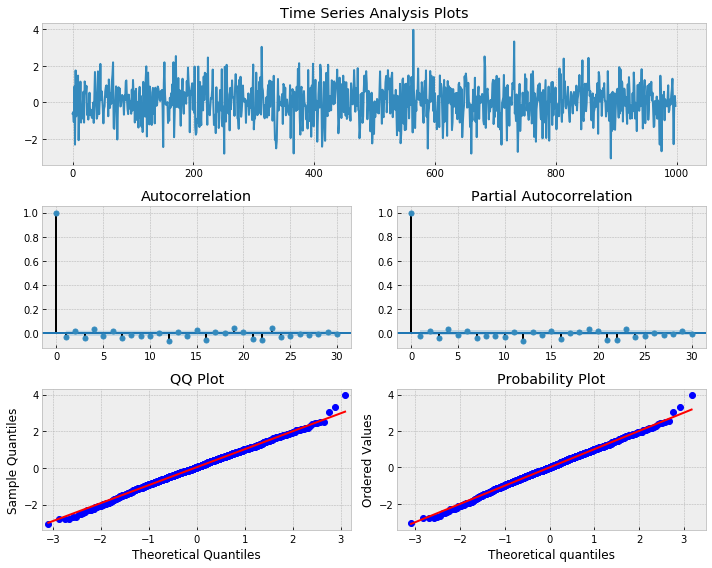

In [11]:
#The first difference of the random walk will look like a white noise process
_ = tsplot(np.diff(x), lags=30)   

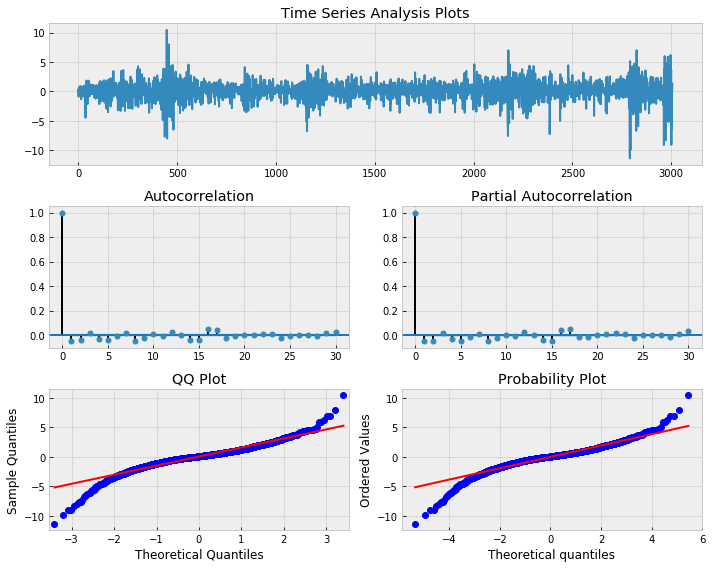

In [14]:
#Do our stock returns look like white noise processes?
#Here is the S&P. It looks mostly normal
_ = tsplot(np.diff(data.SPY), lags=30)

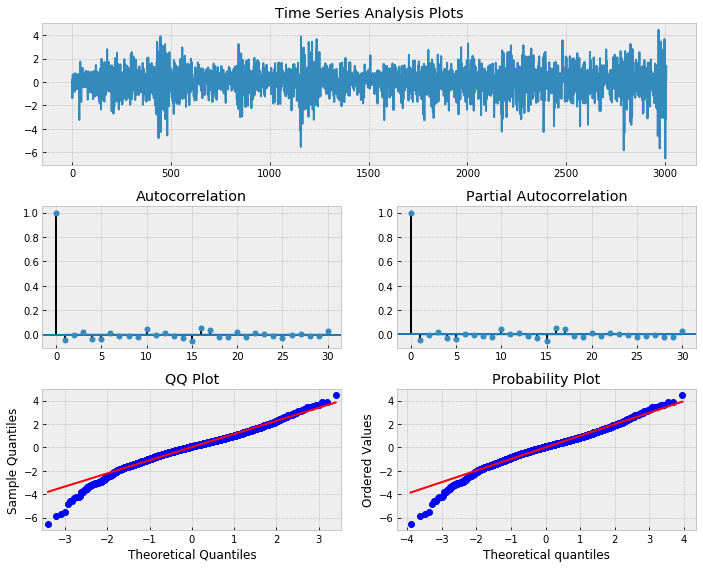

In [15]:
_ = tsplot(np.diff(data.IWM), lags=30)

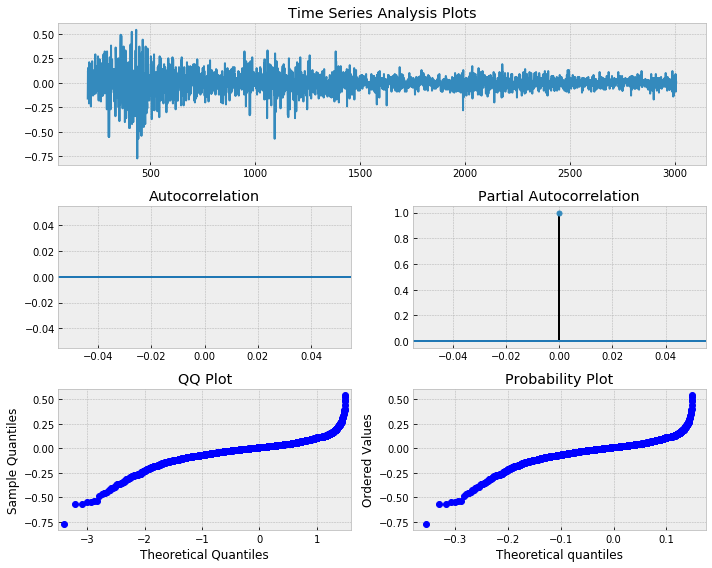

In [16]:
_ = tsplot(np.diff(data.RJI), lags=30)

### Autoregressive Models

In [34]:
#Non-stationarity of financial Time series due to correlated error terms 
#Autoregressive models allow us to use time series with time-dependent error terms

#Autoregressive models are said to have an order p that is characterized by the lag 
#An AR model with order = 1 to is random walk model and not stationary

#If we look at the Russel 2000 etf we see that if we model it as an autoregressive model
#then we can estimate that the order of our model is 21. 
#This is unlikely to be true. 

#this model suggests that future observations are functions of past observations with a lag

max_lag = 30
mdl = smt.AR(lrets.IWM).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(lrets.IWM).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

p('best estimated lag order = {}'.format(est_order))

# best estimated lag order = 21

/Users/justinsimcock/miniconda3/envs/trading/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/justinsimcock/miniconda3/envs/trading/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


best estimated lag order = 21


### Moving Average Models

/Users/justinsimcock/miniconda3/envs/trading/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                    SPY   No. Observations:                 2806
Model:                     ARMA(0, 3)   Log Likelihood                8309.040
Method:                           mle   S.D. of innovations              0.013
Date:                Tue, 18 Dec 2018   AIC                         -16610.081
Time:                        13:53:06   BIC                         -16586.323
Sample:                             0   HQIC                        -16601.506
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.SPY     -0.0819      0.019     -4.348      0.000      -0.119      -0.045
ma.L2.SPY     -0.0728      0.019     -3.782      0.000      -0.111      -0.035
ma.L3.SPY      0.0213      0.018      1.153      0.2

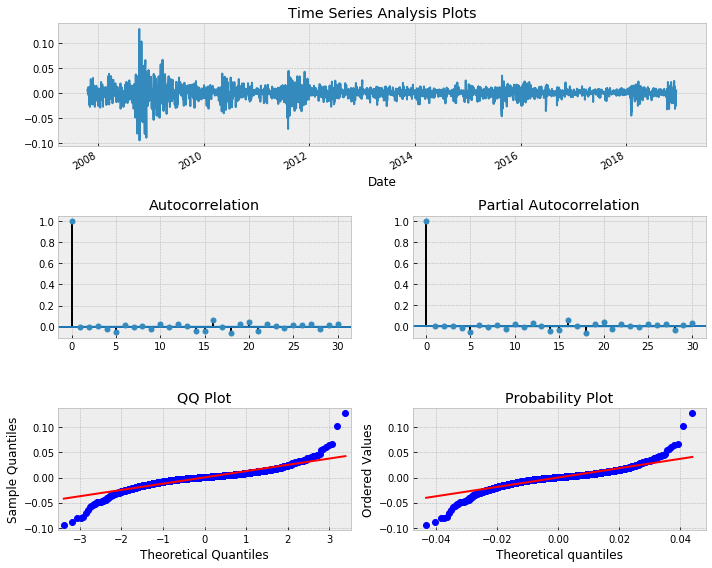

In [35]:
#Instead of modeling time series as a linear combination of the observations
#Model the time series as a linear combinationof the white noise
#By fitting model to the error terms, we can observe the shocks directly

Y = lrets.SPY
mdl = smt.ARMA(Y, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag)

## Autoregressive Moving Average (ARMA) models

In [39]:
#Autoregressive models try to explain the mean reversion and momentum often observed in markets
#Moving average models try to explain the shocks observed in the white noise. 

#ARMA's weakness is that it does not take into account the volatility clustering found in most financial time series

# best_aic = np.inf 
# best_order = None
# best_mdl = None

# rng = range(5) # [0,1,2,3,4,5]
# for i in rng:
#     for j in rng:
#         try:
#             tmp_mdl = smt.ARMA(lrets['SPY'], order=(i, j)).fit(
#                 method='mle', trend='nc'
#             )
#             tmp_aic = tmp_mdl.aic
#             if tmp_aic < best_aic:
#                 best_aic = tmp_aic
#                 best_order = (i, j)
#                 best_mdl = tmp_mdl
#         except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: -16631.69416 | order: (3, 3)


/Users/justinsimcock/miniconda3/envs/trading/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                    SPY   No. Observations:                 2806
Model:                     ARMA(3, 3)   Log Likelihood                8322.847
Method:                           mle   S.D. of innovations              0.012
Date:                Tue, 18 Dec 2018   AIC                         -16631.694
Time:                        14:14:43   BIC                         -16590.118
Sample:                             0   HQIC                        -16616.688
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.SPY     -0.1655      0.144     -1.149      0.251      -0.448       0.117
ar.L2.SPY     -0.5702      0.104     -5.498      0.000      -0.774      -0.367
ar.L3.SPY      0.5523      0.140      3.948      0.0

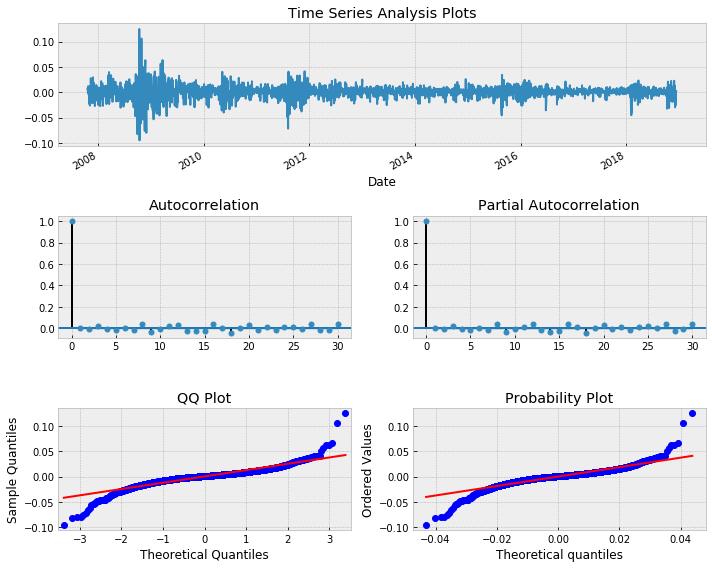

In [40]:
max_lag = 30
Y = lrets.SPY
mdl = smt.ARMA(Y, order=(3, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag)

## ARIMA Models

aic: -16631.69416 | order: (3, 0, 3)


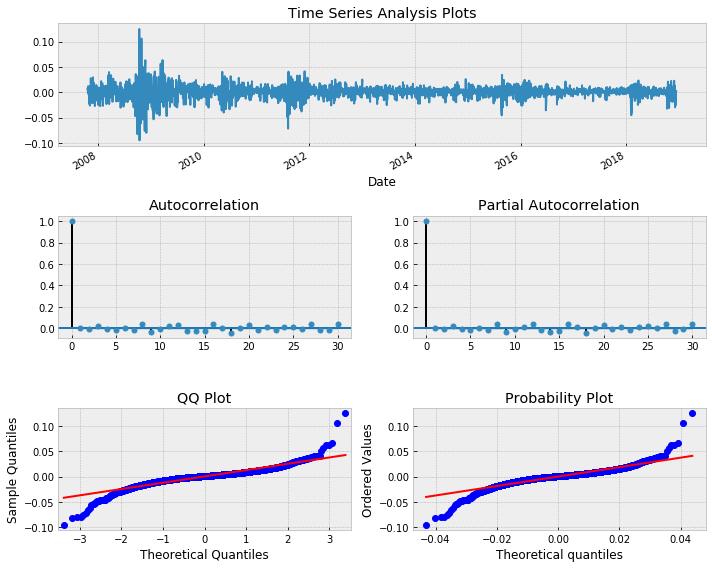

In [42]:
# Fit ARIMA(p, d, q) model to SPY Returns
# pick best order and final model based on aic


#Taking differences of the observations we can turn non-stationary series into stationary white noise

# best_aic = np.inf 
# best_order = None
# best_mdl = None

# pq_rng = range(5) # [0,1,2,3,4]
# d_rng = range(2) # [0,1]
# for i in pq_rng:
#     for d in d_rng:
#         for j in pq_rng:
#             try:
#                 tmp_mdl = smt.ARIMA(lrets.SPY, order=(i,d,j)).fit(method='mle', trend='nc')
#                 tmp_aic = tmp_mdl.aic
#                 if tmp_aic < best_aic:
#                     best_aic = tmp_aic
#                     best_order = (i, d, j)
#                     best_mdl = tmp_mdl
#             except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

#since the returns already capture the first difference, it makes sense that the 
#order of difference would be zero. 

#This ARIMA model, however, has not been able to explain the conditional volatility in our data

In [43]:
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2018-12-12,-0.000064,-0.024489,-0.032164,0.024361,0.032035
2018-12-13,-0.001415,-0.025920,-0.033620,0.023090,0.030790
2018-12-14,0.001513,-0.023031,-0.030744,0.026057,0.033769
2018-12-15,0.000521,-0.024023,-0.031736,0.025065,0.032777
2018-12-16,-0.001730,-0.026276,-0.033989,0.022816,0.030529


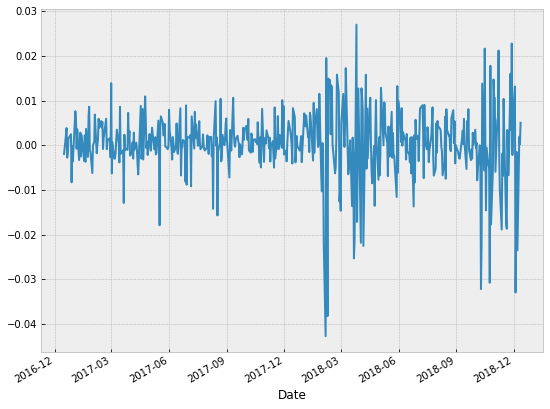

In [99]:
plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = lrets.SPY.iloc[-500:].copy()
ts.plot(ax=ax, label='Spy Returns')
ts_reset = ts.reset_index(drop=True)
# in sample prediction
# pred = best_mdl.predict(ts_reset.iloc[0], ts_reset.iloc[-1])
# pred.plot(ax=ax, style='r-', label='In-sample prediction')

# styles = ['b-', '0.2', '0.75', '0.2', '0.75']
# fc_all.plot(ax=ax, style=styles)
# plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
# plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
# plt.title('{} Day SPY Return Forecast\nARIMA{}'.format(n_steps, best_order))
# plt.legend(loc='best', fontsize=10)

### AutoRegressive Conditional Heteroskedasticiy Models (ARCH)

In [100]:
#autoregressive models that are applied to variance to account for volatility clustering
#Current variance is dependent on variance from previous periods

### General AutoRegressive Conditional Heteroskedasticiy Models (GARCH)

In [ ]:
#ARMA model applied to variance
#It states that there is an autoregressive component as well as a moving average component
#The AR portion will model the variance of the error terms 
#THE MA portion will model variance of the process. 

In [ ]:
#The procedure is as follows:

#Iterate through combinations of ARIMA(p, d, q) models to best fit our time series. 
#Pick the GARCH model orders according to the ARIMA model with lowest AIC.
#Fit the GARCH(p, q) model to our time series.
#Examine the model residuals and squared residuals for autocorrelation

In [103]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = lrets.SPY.ix['2012':'2015']
#res_tup = _get_best_model(TS)

/Users/justinsimcock/miniconda3/envs/trading/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [106]:

p_ = res_tup[1][0]
o_ = res_tup[1][1]
q_ = res_tup[1][2]

# Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
p(res.summary())

                         Constant Mean - ARCH Model Results                         
Dep. Variable:                          SPY   R-squared:                     -14.734
Mean Model:                   Constant Mean   Adj. R-squared:                -14.734
Vol Model:                             ARCH   Log-Likelihood:                1808.69
Distribution:      Standardized Student's t   AIC:                          -3603.37
Method:                  Maximum Likelihood   BIC:                          -3568.98
                                              No. Observations:                 1006
Date:                      Tue, Dec 18 2018   Df Residuals:                      999
Time:                              15:22:30   Df Model:                            7
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

/Users/justinsimcock/miniconda3/envs/trading/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
